### Linear Regression the Bayesian Way 

# This is the variable Sigma Solution 

TODO Often still b instead of sigma needs renaming.

**Note that is still work in progress**

This is a simple notebook demonstrating three approaches to fitting Bayesian Linear Regression:

* The Brute Force evaluation of the unnormalized posterior at all positions 
* The Bayes by Backprop approach

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0  
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)
%matplotlib inline
plt.style.use('default') # No background 
plt.rcParams.update({'font.size': 15}) # Large Fonts

### Creation of data

Creation of some data and definition of parameters

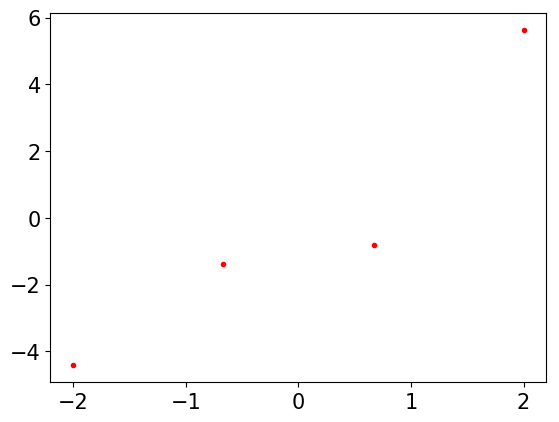

In [4]:
np.random.seed(2)
num = 4
#nbins = 30 used to create the plots for the book (takes quite some time)
nbins = 10
bmin=0.1;bmax=2
amin=-3;amax=8
xmin = -5;xmax = +5;ymin=-40;ymax=40;
nbins_c=30; sigma=1
#x = np.random.normal(0,1,(num,1)) 
x = np.linspace(-2,2,num=num).reshape((num,1))
y = 2 * x[:,0] + np.random.normal(0,sigma,num) 

plt.scatter(x,y, marker='.', color='r')
plt.show()

#d = np.transpose(np.vstack((x[:,0],y)))
#np.savetxt('data_blr_{}.csv'.format(num), d, delimiter=',', header='x,y',comments="",fmt='%.4e');     

### Fitting a linear model (Max Likelihood)
First fit a linear model (corresponding to the maximum likelihood approach)

In [5]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=False)
regr.fit(x,y)
# The coefficients
a_ml = np.float32(regr.coef_)
res = (a_ml * x).flatten() - y
sigma_hat = np.asscalar(np.sqrt(sum(res ** 2)/(len(y)-2)))
sigma_hat = np.float32(sigma_hat)
b_ml = sigma_hat
print('Coefficients a_ml: ', a_ml[0], 'Coefficients b_ml', b_ml)
print('MLE estimate of sigma ', sigma_hat)

Coefficients a_ml:  2.3068368 Coefficients b_ml 1.8157363
MLE estimate of sigma  1.8157363


## Bayesian linear regression
We now assume the following posterior knowlegde 

1. We assume that we know the noise on the data. We can drop this assumption, however, here we want to show the different ways to fit Bayesian models. Estimating $\sigma$ is a bit more complicated, since we cannot assume a Gaussian prior.

2. We assume the following priors on the weight $a \thicksim N(0,1)$ and intercept $b \thicksim N(0,1)$

### Brute Force Bayesian

$$
    P(w|d) \thicksim \frac{P(d|w) P(w)}{P(d)} 
$$

We can calculate $P(d|w) P(w) =: \tt{unnormalized{\_}posterior}$ quite easily. For convenience we calculate the log.

In [6]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
ytensor = y.reshape([len(y),1]) #A
def log_post_unnorm(w): #B
    a_prior = tfd.Normal(loc=0., scale=1.) #C 
    sig_prior = tfd.Normal(loc=0., scale=1.) #C    
    y_prob = tfd.Independent( #D
        tfd.Normal(loc=x*w[0], scale=w[1])
    )
    return (
         tf.reduce_sum(#E
             tf.reduce_sum(y_prob.log_prob(ytensor))+
             a_prior.log_prob(w[0])+ 
             a_prior.log_prob(w[1]))
    )
#A y is now a 2-dimensional tensor with shape (n,1)
#B w holds the two random variables a=w[0] and sigma=w[1] in the Tensor w
#C These are the prior for the slope and intercept
#D Definition of the likelihood (independent Gaussian with fixed sigma)
#E Calculation of the log-posterior as defined in eq.log_post


In [7]:
### Calculation of the values for a and b correponding to the maximum posterior 

In [8]:
w = tf.Variable([[1.0],[2.0]],dtype=tf.float32) #Startvalues
for e in range(300):
    with tf.GradientTape() as tape: 
        loss = -log_post_unnorm(w)
        grads = tape.gradient(loss, w)
        w = tf.Variable(w - 0.01*grads)
a_max_post = w[0].numpy()[0]
b_max_post = w[1].numpy()[0]
print("Maximum A-Posterior a", a_max_post, " b ", b_max_post)#a 1.9960196  b  1.1765033

Maximum A-Posterior a 1.9960196  b  1.1765033


In [9]:
# bmin=0.5;bmax=8.0
# amin=-2;amax=5
bmin=0.5;bmax=8.0
amin=-5;amax=5

nbins= 30
ai, bi = np.mgrid[amin:amax:nbins*1j, bmin:bmax:nbins*1j] #wtf is j?
ws = np.vstack([ai.flatten(), bi.flatten()])
unpost = np.zeros((nbins*nbins))
for i in range((nbins*nbins)):
    unpost[i] = log_post_unnorm(tf.Variable([[ws[0,i]],[ws[1,i]]],dtype=tf.float32))/num
unpost = np.exp(unpost.reshape(ai.shape))
post = unpost / np.sum(unpost) #<-- We normalize

We now evaluate the unnormalized posterior on a $\tt{nbins} \times \tt{nbin}$ grid, ranging from $[-3,+3]$ for the both the intercept and the slope. Outside this range the probability is (nearly) zero and we can use the values to normalize unpost to become a real posterior.

In [10]:
ai.shape, bi.shape, unpost.shape

((30, 30), (30, 30), (30, 30))

<Figure size 600x600 with 0 Axes>

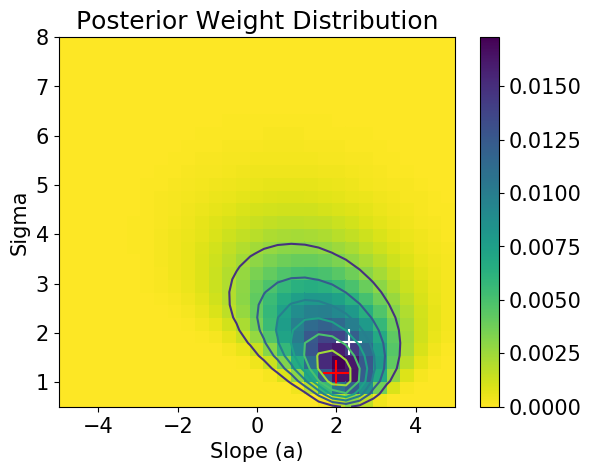

In [11]:
plt.figure(figsize=(6,6))
fig, ax0 = plt.subplots(nrows=1)
cmap = plt.get_cmap('viridis_r',)
im = plt.pcolormesh(ai, bi, post, cmap=cmap)
plt.contour(ai, bi, post)
fig.colorbar(im, ax=ax0)
plt.scatter(a_ml, b_ml, color='w', marker='+',s=333)
plt.scatter(a_max_post, b_max_post, color='r', marker='+',s=333)
plt.xlabel('Slope (a)')
plt.ylabel('Sigma')
plt.title('Posterior Weight Distribution')
plt.savefig('ch06_fblr.pdf')

### Calculation of the predictive distribution $p(y|x,(a,b))$ for fixed parameters $a,b$



In [12]:
def pre_distribution(a,b):
    """
        Return the predictive distribution p(y|(a,b)) for a, b
    """
    canvas0 = np.zeros((nbins_c, nbins_c), dtype=np.float32) #The complete img
    xi = np.zeros((nbins_c, nbins_c), dtype=np.float32)
    yi = np.zeros((nbins_c, nbins_c), dtype=np.float32)
    for j,x_ in enumerate(np.linspace(xmin, xmax, nbins_c,dtype=np.float32)):
        py = tfd.Normal(loc=a*x_,scale=b)
        for i,y_ in enumerate(np.linspace(ymin, ymax, nbins_c,dtype=np.float32)):
            xi[i,j] = x_
            yi[i,j] = y_
            #canvas0[nbins_c-i-1,j] = py.prob(y_)
            canvas0[i,j] = py.prob(y_)
    # This part is a bit tricky. The sum over y for a fixed a should be 1. 
    # However, IMHO due to (more than finite) bin width this is not the case
    # We renormalize
    return canvas0/ np.sum(canvas0,axis=0), xi, yi

### Calculation of the posteriori distribution $p(a,b|D)$

In [14]:
def toBin(a, amin, amax):
    a = np.clip(a, amin, amax)
    return int(0.99999*(a - amin)/(amax-amin) * nbins)

def getProb(a,b):
    return post[toBin(a,amin,amax),toBin(b,bmin,bmax)]

In [15]:
pre_distribution(2,3)[2].dtype

dtype('float32')

In [17]:
xmin = -10;xmax = +10;ymin=-40;ymax=40;
nbins_c=30
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
pyx = np.zeros((nbins_c, nbins_c), dtype=np.float32) #A 
for a in np.linspace(amin, amax, nbins,dtype=np.float32): #B
    for b in np.linspace(bmin, bmax, nbins,dtype=np.float32):
        p_ab = getProb(a,b) #C
        pyx += pre_distribution(a,b)[0] * p_ab
        if (b == bmin):
            print(p_ab)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


2.2003137600604195e-107
1.0479993331557654e-97
1.683847076316372e-88
9.12633242293513e-80
1.668687643222738e-71
1.0292457100051046e-63
2.141485196970394e-56
1.5031059389815945e-49
3.5589840422435143e-43
2.8426567803321033e-37
7.659398906888288e-32
6.96188565987544e-27
2.134630334017291e-22
2.2079387914747407e-18
7.70394757257355e-15
9.067930236502259e-12
3.600531497157168e-09
4.822719072355634e-07
2.179127111966785e-05
0.00033215365371352804
0.0017078901153512397
0.0029624203778390147
0.0017334021004288655
0.00034215019007339896
2.2782499309285554e-05
5.117402047301673e-07
3.8776069840431836e-09
9.91162689155984e-12
8.546527497457094e-15
2.485977579047389e-18


<Figure size 600x600 with 0 Axes>

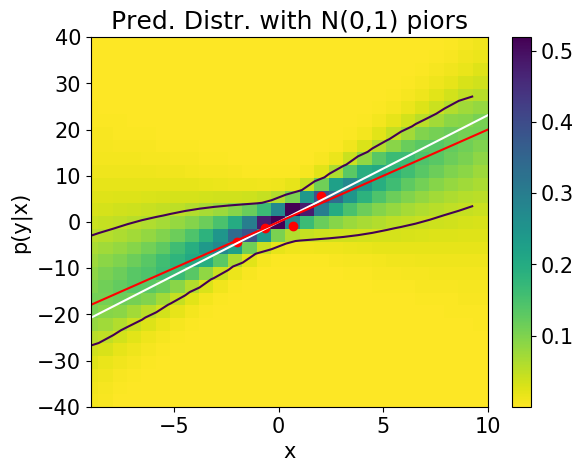

In [18]:
dumm,xi,yi = pre_distribution(a_ml,b_ml)
fig = plt.figure(figsize=(6,6))
fig, ax0 = plt.subplots(nrows=1)
cmap = plt.get_cmap('viridis_r',)
im = plt.pcolormesh(xi, yi, pyx, cmap=cmap)
plt.contour(xi, yi, pyx,[0.05])
fig.colorbar(im, ax=ax0)
plt.scatter(x,y, marker='o',c='r')

plt.plot([xmin, xmax], [a_ml*xmin, a_ml*xmax], color='w', alpha = 1)
plt.plot([xmin, xmax], [a_max_post*xmin, a_max_post*xmax], color='r', alpha = 1)

plt.xlim((xmin+1,xmax)) #Strange hack to avoid white space
plt.xlabel('x')
plt.ylabel('p(y|x)')
plt.title('Pred. Distr. with N(0,1) piors')
plt.savefig('ch06_fblr_pd.pdf')

#### Shortcommings of the brute force approach
So we are done. Let's move to networks and fit the 50 million weights. 
Calculating the unnormalized posterior is easy. Done? Wait a moment. In the above example with the two weights we evaluated the unnormalized probability distribution at $\tt{nbins} \times \tt{nbins}$. If we would also fit the sigma parameter that would be $\tt{nbins}^3$ parameters. So a network with 50 million parameters would need $\tt{nbins}^{50 million}$. Let's be satisfied with only $\tt{nbins}=10$. Then we would have $10^{50'000'000}$. If you could do one billion evaluations per second, that would be still take you $10^{50'000'000}/10^9 = 10^{49'999'991}$ seconds. Even for a small network with 100 weights that would take $10^{100}/10^9 = 10^{91}$ seconds. Fun fact go type `10^100 / 10^9 seconds` into [Wolfram Alpha](https://www.wolframalpha.com/input/?i=10%5E100+%2F+10%5E9+seconds). Solution it will take $3.169 \cdot 10^{83}$ years about 10 billion times longer than the age of the univers! [Forget it Ming!](https://getyarn.io/yarn-clip/ecb8c167-324e-4532-9a96-6b0b958fbe52)

This brute force approach does not do the trick for Bayesian Neural Networks. What next? There is an approach called Markov Chain Monte Carlo MCMC for short. It will work for small problems say 10-100 weights but not for large networks. 

# Comparing with TFP

Below a simple network with 4 hidden layers, haven 1,2,3,4 nodes each.

In [77]:
model = tf.keras.Sequential([
  tfp.layers.DenseReparameterization(1, input_shape=(None,1)),
  tfp.layers.DenseReparameterization(2),
  tfp.layers.DenseReparameterization(3)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_reparameterization_13  (None, None, 1)           3         
_________________________________________________________________
dense_reparameterization_14  (None, None, 2)           6         
_________________________________________________________________
dense_reparameterization_15  (None, None, 3)           15        
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


### Rebuilding the simple network

Building a simple network. We do two thinks in a addition to the default:

* First:  we also want to have a prior on the bias
* Second: we dived the KL loss so it is also per training example (as in the NLL term)


In [19]:
# Rescaling divergence, see above comment
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (num * 1.0)

def NLL(y, distr):
    return -distr.log_prob(y) 
    
def my_dist(params):
    return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))
# both parameters are learnable
      

from tensorflow.keras.layers import Input, Add
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

x_ = Input(shape=(1,))
mu_sigm = tfp.layers.DenseReparameterization(2, 
                                       kernel_divergence_fn=kernel_divergence_fn,
                                       bias_divergence_fn=kernel_divergence_fn,
                                       bias_prior_fn=tfp.layers.util.default_multivariate_normal_fn,#A
                                       bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn())(x_)
dist = tfp.layers.DistributionLambda(my_dist)(mu_sigm) #C #D
model = Model(inputs=x_, outputs=dist)
model.compile(Adam(learning_rate=0.001), loss=NLL)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_reparameterization (De (None, 2)                 8         
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [20]:
hist = model.fit(x, ytensor, epochs=5000, batch_size=num, verbose=False)

array([[2.1783874 , 0.49908605]], dtype=float32)

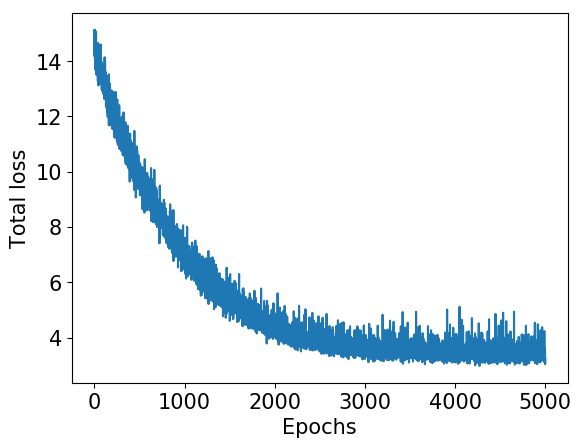

In [24]:
plt.plot(hist.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Total loss')


model.weights[0].numpy()

In [ ]:
epochs=7000
#logger2 = Logger(epochs, num_weights=8)
lr = 0.0005
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
w_0=(0,-1.0,0,-1.0,0,-1.0,0,-1)  #The Initial conditions
w = tf.Variable(w_0) #We need all variational parameters in one tensor 
e = tfd.Normal(loc=0., scale=1.) # The noise term
for i in range(epochs):
    with tf.GradientTape() as tape: 
        # The linear regression with the reparameterization trick
             
        
        #####
        # Mu
        #The slope for mu 
        sa_mu = tf.math.softplus(w[1])
        a_mu = w[0] + e.sample() * sa_mu #Sample a ~ N(mu_a, sigma_a) with reparametrization trick
        
        #The intercept for mu
        sb_mu = tf.math.softplus(w[3])
        b_mu  = w[2] + e.sample() * sb_mu
        
        mu = a_mu * x + b_mu
        
        #####
        # Sigma
        #The slope for sigma
        sa_s = tf.math.softplus(w[5])
        a_s = w[4] + e.sample() * sa_s
        
        #The intercept for sigma
        sb_s = tf.math.softplus(w[7])
        b_s  = w[6] + e.sample() * sb_s
        
        sig = tf.math.softplus(a_s * x + b_s)
        
        y_prob = tfd.Normal(loc=mu, scale=sig)
        loss_nll = -tf.reduce_sum(y_prob.log_prob(ytensor))
        #KL-Divergence with Gaussian Priors 
        loss_kl = -0.5*(1.0 + tf.math.log(sa_mu*sa_mu) - sa_mu*sa_mu - w[0]*w[0]  + 
                              tf.math.log(sb_mu*sb_mu) - sb_mu*sb_mu - w[2]*w[2]  + 
                              tf.math.log(sa_s *sa_s ) - sa_s *sa_s  - w[4]*w[4]  +
                              tf.math.log(sb_s *sb_s ) - sb_s *sb_s  - w[6]*w[6])
        
        loss = loss_nll + loss_kl
    grads = tape.gradient(loss, w)
    #w = w - 0.0001*grads # Attention: Does not work in eager
    w = tf.Variable(w - lr*grads) # Gradient Descent   
    #logger2.log(i, i, w, grads, loss, loss_kl, loss_nll)
    if i % 500 == 0:
        print(i, " loss ", loss.numpy())
        print('a_mu', w[0].numpy(),'b_mu', w[2].numpy(), ' sigma_mean', tf.math.softplus(w[6]).numpy())

0  loss  62.21003
a_mu 0.018597981 b_mu 0.0014348273  sigma_mean 0.7118741
500  loss  14.197942
a_mu 1.5055153 b_mu -0.23747876  sigma_mean 1.6005847
1000  loss  13.7275505
a_mu 1.8011531 b_mu -0.35788673  sigma_mean 1.4405402
1500  loss  12.504986
a_mu 1.8993913 b_mu -0.4024148  sigma_mean 1.3491428
2000  loss  12.6097145
a_mu 1.9281372 b_mu -0.4273276  sigma_mean 1.2752008
2500  loss  12.049941
a_mu 1.8951379 b_mu -0.4082481  sigma_mean 1.2843906
3000  loss  13.116458
a_mu 1.9042262 b_mu -0.40407193  sigma_mean 1.2890025
3500  loss  13.697042
a_mu 1.9852874 b_mu -0.4388539  sigma_mean 1.3250026
4000  loss  13.050182
a_mu 1.9223385 b_mu -0.3875889  sigma_mean 1.32787
4500  loss  14.364921
a_mu 1.8883479 b_mu -0.38189816  sigma_mean 1.3135484
5000  loss  13.05768
a_mu 1.9037504 b_mu -0.39403212  sigma_mean 1.283395
5500  loss  13.736893
a_mu 1.8771813 b_mu -0.38308403  sigma_mean 1.2685897
6000  loss  11.606342
a_mu 1.8887204 b_mu -0.40406686  sigma_mean 1.2615694


In [99]:
# Rescaling divergence, see above comment
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (num * 1.0)

def NLL(y, distr):
    return -distr.log_prob(y) 
    
def my_dist(params):
    return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))
# both parameters are learnable
      

from tensorflow.keras.layers import Input, Add
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

x_ = Input(shape=(1,))
mu_sigm = tfp.layers.DenseReparameterization(2, 
                                       kernel_divergence_fn=kernel_divergence_fn,
                                       bias_divergence_fn=kernel_divergence_fn,
                                       bias_prior_fn=tfp.layers.util.default_multivariate_normal_fn,#A
                                       bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn())(x_)
dist = tfp.layers.DistributionLambda(my_dist)(mu_sigm) #C #D
model = Model(inputs=x_, outputs=dist)
model.compile(Adam(learning_rate=0.01), loss=NLL)

In [152]:
hist = model.fit(x, ytensor, epochs=5000, batch_size=num, verbose=False)

In [155]:
model.weights[0]

<tf.Variable 'dense_reparameterization_11/kernel_posterior_loc:0' shape=(1, 2) dtype=float32, numpy=array([[2.1448205 , 0.50134856]], dtype=float32)>

Text(0, 0.5, 'Total loss')

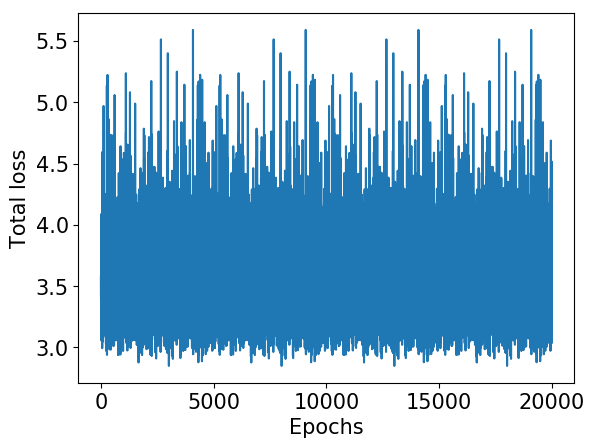

In [153]:
plt.plot(hist.history['loss']*4)
plt.xlabel('Epochs')
plt.ylabel('Total loss')

In [147]:
weights[epochs-1,]

array([ 1.91194475, -1.25465262, -0.41596645, -0.71675694,  0.37345457,
       -1.17457378])

### Some Animation

Have been done with R using gganimate. The transformation to mp4 with: https://ezgif.com/gif-to-mp4

![Animation](grads_n3_lr_2e-3_woff2.gif)

* Animation on [gif](https://github.com/tensorchiefs/dl_book_playground/blob/master/grads_n3_lr_2e-3_woff2.gif)
as [mp4](https://github.com/tensorchiefs/dl_book_playground/blob/master/grads_n3_lr_2e-3_woff2.mp4)

* Losses [gif](https://github.com/tensorchiefs/dl_book_playground/blob/master/losses_n3_lr_2e-3_woff2.gif)

* Fit [gif](https://github.com/tensorchiefs/dl_book_playground/blob/master/fit_n3_lr_2e-3_woff2)

### Comparing with TF 
